# JAXMonotonicRegressor: Monotonic Neural Networks with Uncertainty

This notebook demonstrates using Monotonic Neural Networks for regression tasks where prior knowledge dictates that the output should increase or decrease with respect to specific inputs.

## What are Monotonic Neural Networks?

Monotonic Neural Networks are neural networks whose output is guaranteed to be **monotonic with respect to specified inputs**. This is achieved through:

1. **Nonnegative weights** from input to output for increasing monotonicity
2. **Sign flipping** of inputs for decreasing monotonicity
3. **Nondecreasing activations** (softplus or ReLU)

The monotonicity guarantee means:
- If feature $x_i$ increases, the output $f(x)$ is guaranteed to increase (or decrease)
- Prior domain knowledge can be directly encoded into the model
- Predictions are physically consistent with known relationships

## When to Use Monotonic Neural Networks

Monotonic constraints are valuable when you have **prior knowledge** about the direction of relationships:

| Domain | Example | Monotonicity |
|--------|---------|---------------|
| Chemistry | Reaction rate vs temperature | Increasing |
| Economics | Price vs quantity demanded | Decreasing |
| Medicine | Drug dose vs effect | Often increasing (up to saturation) |
| Materials | Stress vs strain (elastic region) | Increasing |
| Engineering | Power consumption vs load | Increasing |

## References

- Sill, J. (1998). Monotonic Networks. NeurIPS 1997. [link](https://papers.nips.cc/paper_files/paper/1997/hash/83adc9225e4deb67d7ce42d58fe5157c-Abstract.html)
- Daniels, H., & Velikova, M. (2010). Monotone and Partially Monotone Neural Networks. IEEE TNN. [link](https://pubmed.ncbi.nlm.nih.gov/20371402/)
- Wehenkel, A., & Louppe, G. (2019). Unconstrained Monotonic Neural Networks. NeurIPS 2019. [link](https://proceedings.neurips.cc/paper_files/paper/2019/file/2a084e55c87b1ebcdaad1f62fdbbac8e-Paper.pdf)
- Liu, S., et al. (2020). Certified Monotonic Neural Networks. NeurIPS 2020. [link](https://proceedings.neurips.cc/paper/2020/hash/b139aeda1c2914e3b579aafd3ceeb1bd-Abstract.html)

## LLPR Uncertainty Quantification

This implementation includes **Last-Layer Prediction Rigidity (LLPR)** for uncertainty quantification:

- Bigi, F., Chong, S., Ceriotti, M., & Grasselli, F. (2024). A prediction rigidity formalism for low-cost uncertainties in trained neural networks. Machine Learning: Science and Technology. [link](https://iopscience.iop.org/article/10.1088/2632-2153/ad805f)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import os

os.environ["JAX_PLATFORM_NAME"] = "cpu"

from pycse.sklearn.jax_monotonic import JAXMonotonicRegressor

# Set random seed for reproducibility
np.random.seed(42)

## How Monotonic Networks Guarantee Monotonicity

The network architecture enforces monotonicity through careful constraints:

### The Architecture

For a feature $x_i$ with **increasing** monotonicity:
- All weights connecting $x_i$ to the output are constrained to be **nonnegative**
- Activations are **nondecreasing** (softplus, ReLU)

For a feature $x_i$ with **decreasing** monotonicity:
- The input is **sign-flipped**: $x'_i = -x_i$
- Weights are still nonnegative, but since $x'_i = -x_i$:
  - If $x_i$ increases, $x'_i$ decreases
  - The output decreases (due to nonnegative weights with decreasing input)

### Mathematical Guarantee

For the gradient with respect to a monotonically increasing feature:

$$\frac{\partial f}{\partial x_i} \geq 0 \quad \text{for all } x$$

For a monotonically decreasing feature:

$$\frac{\partial f}{\partial x_i} \leq 0 \quad \text{for all } x$$

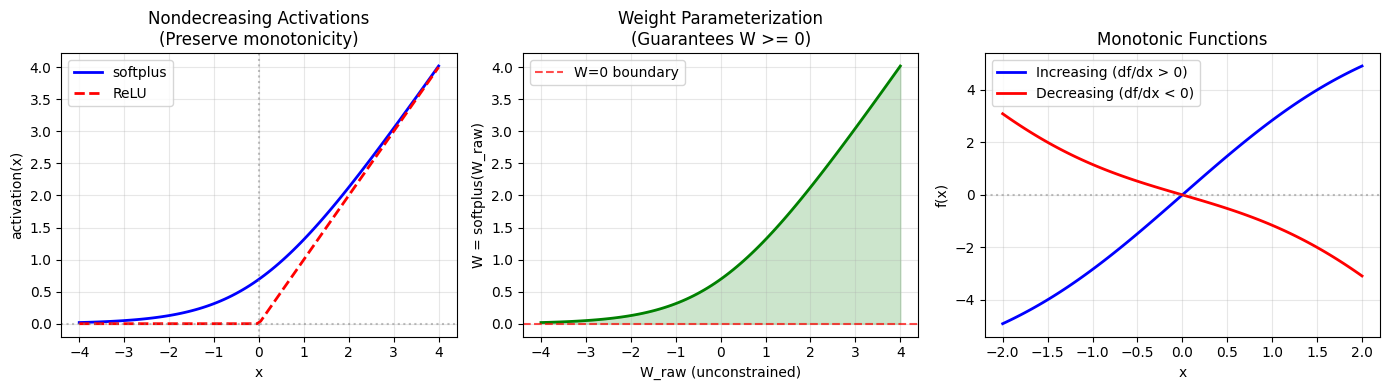

Key insight: Nonnegative weights + nondecreasing activations = monotonic output


In [2]:
# Visualize the key components that guarantee monotonicity

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 1. Softplus activation is nondecreasing
x_act = np.linspace(-4, 4, 100)
softplus = np.log(1 + np.exp(x_act))
relu = np.maximum(0, x_act)

ax = axes[0]
ax.plot(x_act, softplus, "b-", linewidth=2, label="softplus")
ax.plot(x_act, relu, "r--", linewidth=2, label="ReLU")
ax.axhline(0, color="gray", linestyle=":", alpha=0.5)
ax.axvline(0, color="gray", linestyle=":", alpha=0.5)
ax.set_xlabel("x")
ax.set_ylabel("activation(x)")
ax.set_title("Nondecreasing Activations\n(Preserve monotonicity)")
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Softplus parameterization ensures W >= 0
w_raw = np.linspace(-4, 4, 100)
w_positive = np.log(1 + np.exp(w_raw))

ax = axes[1]
ax.plot(w_raw, w_positive, "g-", linewidth=2)
ax.axhline(0, color="red", linestyle="--", alpha=0.7, label="W=0 boundary")
ax.fill_between(w_raw, 0, w_positive, alpha=0.2, color="green")
ax.set_xlabel("W_raw (unconstrained)")
ax.set_ylabel("W = softplus(W_raw)")
ax.set_title("Weight Parameterization\n(Guarantees W >= 0)")
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Monotonicity visualization
ax = axes[2]
x_demo = np.linspace(-2, 2, 100)
y_increasing = 2 * x_demo + np.sin(x_demo)  # Monotonically increasing
y_decreasing = -2 * x_demo + np.sin(x_demo)  # Monotonically decreasing

ax.plot(x_demo, y_increasing, "b-", linewidth=2, label="Increasing (df/dx > 0)")
ax.plot(x_demo, y_decreasing, "r-", linewidth=2, label="Decreasing (df/dx < 0)")
ax.axhline(0, color="gray", linestyle=":", alpha=0.5)
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
ax.set_title("Monotonic Functions")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key insight: Nonnegative weights + nondecreasing activations = monotonic output")

## 1. Basic Usage: Monotonically Increasing Function

Let's start with a simple example where the output increases with the input.

In [3]:
# Generate data from a monotonically increasing function
# Example: Arrhenius-like relationship (simplified)
np.random.seed(42)
n_samples = 150

X_inc = np.random.uniform(0.5, 3.0, (n_samples, 1))
# True function: y = x^2 + 0.5*x (monotonically increasing for x > 0)
y_inc = X_inc[:, 0] ** 2 + 0.5 * X_inc[:, 0] + 0.2 * np.random.randn(n_samples)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_inc, y_inc, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 120
Test samples: 30


In [4]:
# Train monotonic model with increasing constraint
model_inc = JAXMonotonicRegressor(
    hidden_dims=(32, 32),
    monotonicity=1,  # +1 = increasing
    epochs=500,
    random_state=42,
    verbose=True,
)
model_inc.fit(X_train, y_train)

# Evaluate
r2 = model_inc.score(X_test, y_test)
print(f"\nR² score on test set: {r2:.4f}")

Metal device set to: Apple M4 Pro


W0000 00:00:1767552265.255858 17792645 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1767552265.268211 17792645 service.cc:145] XLA service 0x60000023c600 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767552265.268229 17792645 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1767552265.269408 17792645 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1767552265.269415 17792645 mps_client.cc:384] XLA backend will use up to 51539132416 bytes on device 0 for SimpleAllocator.


Epoch 100/500, Loss: 0.028763
Epoch 200/500, Loss: 0.028475
Epoch 300/500, Loss: 0.006028
Epoch 400/500, Loss: 0.007001
Epoch 500/500, Loss: 0.007034
LLPR calibrated: α²=7.85e-01, ζ²=2.64e-08, NLL=0.0943

R² score on test set: 0.9957


In [5]:
# Verify monotonicity: check that gradient is always positive
X_dense = np.linspace(0.5, 3.0, 100).reshape(-1, 1)
y_pred = model_inc.predict(X_dense)
grads = model_inc.predict_gradient(X_dense)

print("Gradient verification for monotonically INCREASING model:")
print(f"  Min gradient: {grads.min():.6f}")
print(f"  Max gradient: {grads.max():.6f}")
print(f"  All gradients >= 0: {np.all(grads >= -1e-6)}")

Gradient verification for monotonically INCREASING model:
  Min gradient: 2.942753
  Max gradient: 5.935910
  All gradients >= 0: True


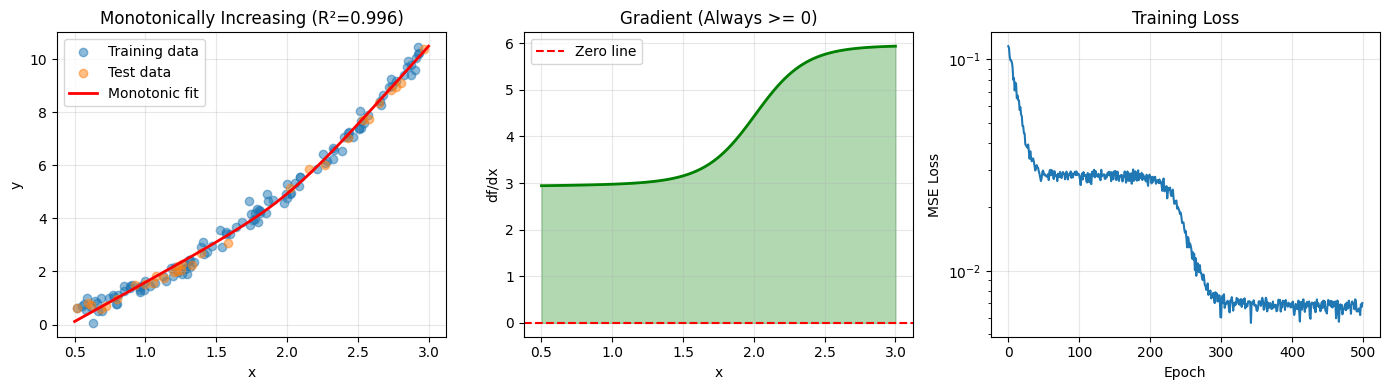

In [6]:
# Visualize
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Predictions
ax = axes[0]
ax.scatter(X_train, y_train, alpha=0.5, label="Training data")
ax.scatter(X_test, y_test, alpha=0.5, label="Test data")
ax.plot(X_dense, y_pred, "r-", linewidth=2, label="Monotonic fit")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"Monotonically Increasing (R²={r2:.3f})")
ax.legend()
ax.grid(True, alpha=0.3)

# Gradient (should be positive)
ax = axes[1]
ax.plot(X_dense, grads, "g-", linewidth=2)
ax.axhline(0, color="red", linestyle="--", label="Zero line")
ax.fill_between(X_dense.ravel(), 0, grads.ravel(), alpha=0.3, color="green")
ax.set_xlabel("x")
ax.set_ylabel("df/dx")
ax.set_title("Gradient (Always >= 0)")
ax.legend()
ax.grid(True, alpha=0.3)

# Learning curve
ax = axes[2]
ax.plot(model_inc.loss_history_)
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE Loss")
ax.set_title("Training Loss")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Monotonically Decreasing Function

Now let's demonstrate a decreasing monotonic relationship, such as demand vs price.

In [7]:
# Generate data from a monotonically decreasing function
# Example: Demand curve - as price increases, demand decreases
np.random.seed(42)
n_samples = 150

X_dec = np.random.uniform(1, 10, (n_samples, 1))  # Price
# True function: demand = 100 / price + small noise
y_dec = 100 / X_dec[:, 0] + 5 + 2 * np.random.randn(n_samples)  # Demand

# Split
X_train_dec, X_test_dec, y_train_dec, y_test_dec = train_test_split(
    X_dec, y_dec, test_size=0.2, random_state=42
)

In [8]:
# Train monotonic model with decreasing constraint
model_dec = JAXMonotonicRegressor(
    hidden_dims=(32, 32),
    monotonicity=-1,  # -1 = decreasing
    epochs=500,
    random_state=42,
)
model_dec.fit(X_train_dec, y_train_dec)

r2_dec = model_dec.score(X_test_dec, y_test_dec)
print(f"R² score on test set: {r2_dec:.4f}")

R² score on test set: 0.9740


In [9]:
# Verify monotonicity: gradients should be negative
X_dense_dec = np.linspace(1, 10, 100).reshape(-1, 1)
y_pred_dec = model_dec.predict(X_dense_dec)
grads_dec = model_dec.predict_gradient(X_dense_dec)

print("Gradient verification for monotonically DECREASING model:")
print(f"  Min gradient: {grads_dec.min():.6f}")
print(f"  Max gradient: {grads_dec.max():.6f}")
print(f"  All gradients <= 0: {np.all(grads_dec <= 1e-6)}")

Gradient verification for monotonically DECREASING model:
  Min gradient: -30.865415
  Max gradient: -2.350349
  All gradients <= 0: True


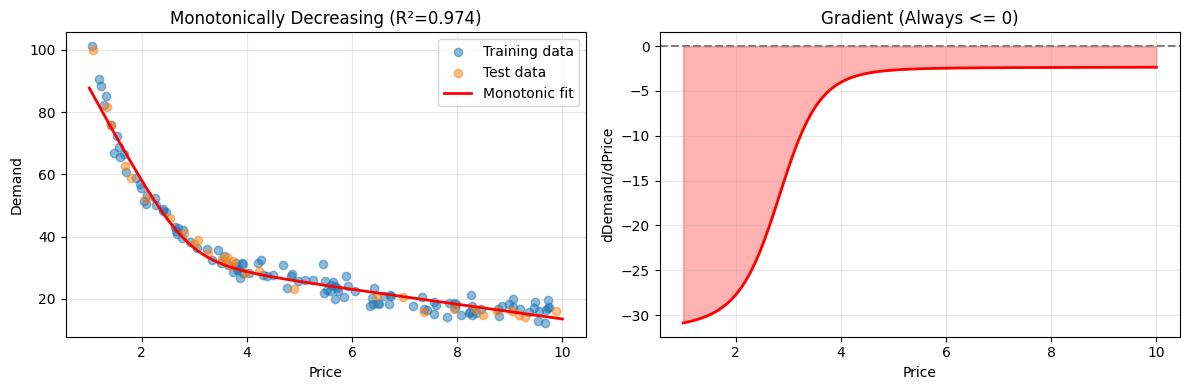

In [10]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Predictions
ax = axes[0]
ax.scatter(X_train_dec, y_train_dec, alpha=0.5, label="Training data")
ax.scatter(X_test_dec, y_test_dec, alpha=0.5, label="Test data")
ax.plot(X_dense_dec, y_pred_dec, "r-", linewidth=2, label="Monotonic fit")
ax.set_xlabel("Price")
ax.set_ylabel("Demand")
ax.set_title(f"Monotonically Decreasing (R²={r2_dec:.3f})")
ax.legend()
ax.grid(True, alpha=0.3)

# Gradient (should be negative)
ax = axes[1]
ax.plot(X_dense_dec, grads_dec, "r-", linewidth=2)
ax.axhline(0, color="gray", linestyle="--")
ax.fill_between(X_dense_dec.ravel(), 0, grads_dec.ravel(), alpha=0.3, color="red")
ax.set_xlabel("Price")
ax.set_ylabel("dDemand/dPrice")
ax.set_title("Gradient (Always <= 0)")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Mixed Monotonicity: Multiple Features

In real applications, you often have multiple features with different monotonicity constraints. For example:

- **Chemical reaction rate**: Increases with temperature, decreases with inhibitor concentration
- **House price**: Increases with area, decreases with distance to city center

In [11]:
# Generate data with mixed monotonicity
# Example: House price = f(area, distance_to_center, age_normalized)
#   - Increasing with area
#   - Decreasing with distance
#   - Unconstrained with age (might be complex)

np.random.seed(42)
n_samples = 300

# Features
area = np.random.uniform(50, 200, n_samples)  # m²
distance = np.random.uniform(1, 20, n_samples)  # km
age = np.random.uniform(0, 50, n_samples)  # years

X_mixed = np.column_stack([area, distance, age])

# Price function:
#   - Increases with area (coef > 0)
#   - Decreases with distance (coef < 0)
#   - Age has nonlinear effect (vintage premium, then depreciation)
y_mixed = (
    2000 * area  # Increasing
    - 15000 * np.sqrt(distance)  # Decreasing
    + 5000 * np.sin(age / 10)  # Nonlinear, unconstrained
    + 100000  # Base price
    + 10000 * np.random.randn(n_samples)  # Noise
)

# Split
X_train_mix, X_test_mix, y_train_mix, y_test_mix = train_test_split(
    X_mixed, y_mixed, test_size=0.2, random_state=42
)

print("Features:")
print("  x0: Area (m²) - should be INCREASING")
print("  x1: Distance to center (km) - should be DECREASING")
print("  x2: Age (years) - UNCONSTRAINED")

Features:
  x0: Area (m²) - should be INCREASING
  x1: Distance to center (km) - should be DECREASING
  x2: Age (years) - UNCONSTRAINED


In [12]:
# Train with mixed monotonicity constraints
model_mixed = JAXMonotonicRegressor(
    hidden_dims=(64, 64),
    monotonicity=[1, -1, 0],  # area: +, distance: -, age: unconstrained
    epochs=500,
    random_state=42,
    verbose=True,
)
model_mixed.fit(X_train_mix, y_train_mix)

r2_mix = model_mixed.score(X_test_mix, y_test_mix)
print(f"\nR² score on test set: {r2_mix:.4f}")

Epoch 100/500, Loss: 0.016644
Epoch 200/500, Loss: 0.011544
Epoch 300/500, Loss: 0.010739
Epoch 400/500, Loss: 0.011044
Epoch 500/500, Loss: 0.010759
LLPR calibrated: α²=1.00e+02, ζ²=1.00e-08, NLL=8795585.8686

R² score on test set: 0.9834


In [13]:
# Verify monotonicity constraints on test data
grads_mix = model_mixed.predict_gradient(X_test_mix)

print("Gradient verification:")
print(
    f"  Area (x0, increasing):     min={grads_mix[:, 0].min():10.2f}, max={grads_mix[:, 0].max():10.2f}, all >= 0: {np.all(grads_mix[:, 0] >= -1e-6)}"
)
print(
    f"  Distance (x1, decreasing): min={grads_mix[:, 1].min():10.2f}, max={grads_mix[:, 1].max():10.2f}, all <= 0: {np.all(grads_mix[:, 1] <= 1e-6)}"
)
print(
    f"  Age (x2, unconstrained):   min={grads_mix[:, 2].min():10.2f}, max={grads_mix[:, 2].max():10.2f} (any sign)"
)

Gradient verification:
  Area (x0, increasing):     min=   2003.11, max=   2013.09, all >= 0: True
  Distance (x1, decreasing): min=  -2530.25, max=  -2526.81, all <= 0: True
  Age (x2, unconstrained):   min=   -134.85, max=    -91.60 (any sign)


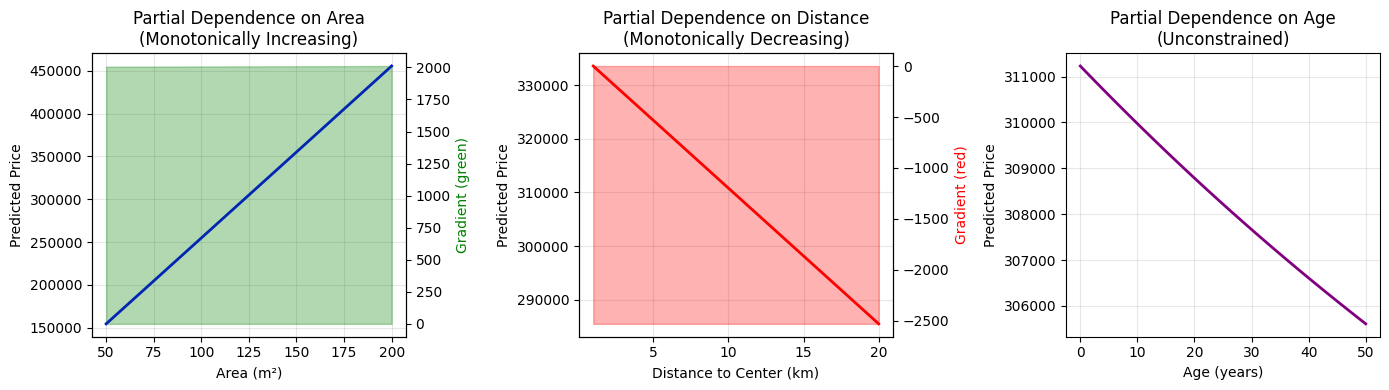

In [14]:
# Visualize partial dependencies
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Partial dependence on area (at median distance and age)
areas = np.linspace(50, 200, 50)
X_area = np.column_stack([areas, np.full(50, np.median(distance)), np.full(50, np.median(age))])
y_area = model_mixed.predict(X_area)
g_area = model_mixed.predict_gradient(X_area)

ax = axes[0]
ax.plot(areas, y_area, "b-", linewidth=2)
ax.set_xlabel("Area (m²)")
ax.set_ylabel("Predicted Price")
ax.set_title("Partial Dependence on Area\n(Monotonically Increasing)")
ax.grid(True, alpha=0.3)

# Verify it's increasing
ax_twin = ax.twinx()
ax_twin.fill_between(areas, 0, g_area[:, 0], alpha=0.3, color="green")
ax_twin.set_ylabel("Gradient (green)", color="green")

# Partial dependence on distance
distances = np.linspace(1, 20, 50)
X_dist = np.column_stack([np.full(50, np.median(area)), distances, np.full(50, np.median(age))])
y_dist = model_mixed.predict(X_dist)
g_dist = model_mixed.predict_gradient(X_dist)

ax = axes[1]
ax.plot(distances, y_dist, "r-", linewidth=2)
ax.set_xlabel("Distance to Center (km)")
ax.set_ylabel("Predicted Price")
ax.set_title("Partial Dependence on Distance\n(Monotonically Decreasing)")
ax.grid(True, alpha=0.3)

ax_twin = ax.twinx()
ax_twin.fill_between(distances, 0, g_dist[:, 1], alpha=0.3, color="red")
ax_twin.set_ylabel("Gradient (red)", color="red")

# Partial dependence on age (unconstrained)
ages = np.linspace(0, 50, 50)
X_age = np.column_stack([np.full(50, np.median(area)), np.full(50, np.median(distance)), ages])
y_age = model_mixed.predict(X_age)

ax = axes[2]
ax.plot(ages, y_age, "purple", linewidth=2)
ax.set_xlabel("Age (years)")
ax.set_ylabel("Predicted Price")
ax.set_title("Partial Dependence on Age\n(Unconstrained)")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Uncertainty Quantification with LLPR

The `JAXMonotonicRegressor` includes **Last-Layer Prediction Rigidity (LLPR)** for uncertainty quantification. This provides calibrated uncertainty estimates without ensemble methods.

The uncertainty formula:
$$\sigma^2_* = \alpha^2 f_*^T (F^T F + \zeta^2 I)^{-1} f_*$$

where $f_*$ is the last-layer feature vector and $F$ is the matrix of training features.

In [15]:
# Predict with uncertainty
y_pred_unc, y_std = model_inc.predict_with_uncertainty(X_test)

print(f"Predictions shape: {y_pred_unc.shape}")
print(f"Uncertainties shape: {y_std.shape}")
print(f"\nMean uncertainty: {np.mean(y_std):.4f}")
print(f"Uncertainty range: [{y_std.min():.4f}, {y_std.max():.4f}]")

Predictions shape: (30,)
Uncertainties shape: (30,)

Mean uncertainty: 0.6833
Uncertainty range: [0.5184, 1.3080]


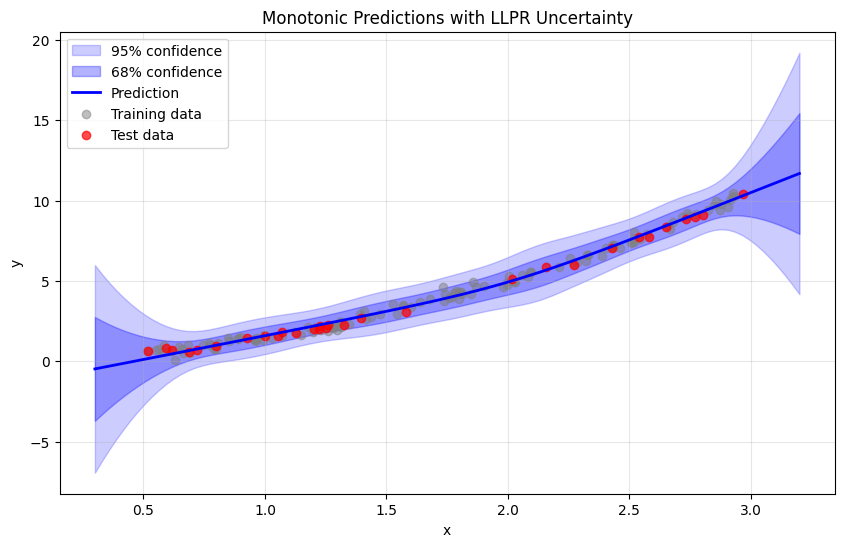

Note: Uncertainty increases outside the training data range!


In [16]:
# Visualize predictions with uncertainty bands
X_plot = np.linspace(0.3, 3.2, 100).reshape(-1, 1)
y_pred_plot, y_std_plot = model_inc.predict_with_uncertainty(X_plot)

plt.figure(figsize=(10, 6))

# Confidence intervals
plt.fill_between(
    X_plot.ravel(),
    y_pred_plot - 2 * y_std_plot,
    y_pred_plot + 2 * y_std_plot,
    alpha=0.2,
    color="blue",
    label="95% confidence",
)
plt.fill_between(
    X_plot.ravel(),
    y_pred_plot - y_std_plot,
    y_pred_plot + y_std_plot,
    alpha=0.3,
    color="blue",
    label="68% confidence",
)

# Mean prediction
plt.plot(X_plot, y_pred_plot, "b-", linewidth=2, label="Prediction")

# Data
plt.scatter(X_train, y_train, alpha=0.5, c="gray", label="Training data")
plt.scatter(X_test, y_test, alpha=0.7, c="red", label="Test data")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Monotonic Predictions with LLPR Uncertainty")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Note: Uncertainty increases outside the training data range!")

In [17]:
# Demonstrate that uncertainty increases away from training data
X_near = X_train[:5]  # Points near training data
X_far = X_train[:5] + 5.0  # Points far from training data

_, std_near = model_inc.predict_with_uncertainty(X_near)
_, std_far = model_inc.predict_with_uncertainty(X_far)

print("Uncertainty comparison:")
print(f"  Near training data: mean std = {np.mean(std_near):.4f}")
print(f"  Far from training data: mean std = {np.mean(std_far):.4f}")
print(f"  Ratio: {np.mean(std_far) / np.mean(std_near):.2f}x")

Uncertainty comparison:
  Near training data: mean std = 0.7393
  Far from training data: mean std = 61.8424
  Ratio: 83.65x


## 5. Comparison: With and Without Monotonicity Constraints

Let's see what happens when we ignore known monotonicity constraints.

In [18]:
# Generate sparse, noisy data where unconstrained model might violate monotonicity
np.random.seed(123)
n_sparse = 30

X_sparse = np.random.uniform(0, 5, (n_sparse, 1))
y_sparse = 3 * X_sparse[:, 0] + 1.5 * np.random.randn(n_sparse)  # Noisy linear increasing

# Train with monotonicity constraint
model_constrained = JAXMonotonicRegressor(
    hidden_dims=(16, 16),
    monotonicity=1,
    epochs=300,
    random_state=42,
)
model_constrained.fit(X_sparse, y_sparse)

# Train without constraint (all features unconstrained)
model_unconstrained = JAXMonotonicRegressor(
    hidden_dims=(16, 16),
    monotonicity=0,  # No constraint
    epochs=300,
    random_state=42,
)
model_unconstrained.fit(X_sparse, y_sparse)

JAXMonotonicRegressor(epochs=300, hidden_dims=(16, 16), monotonicity=0)

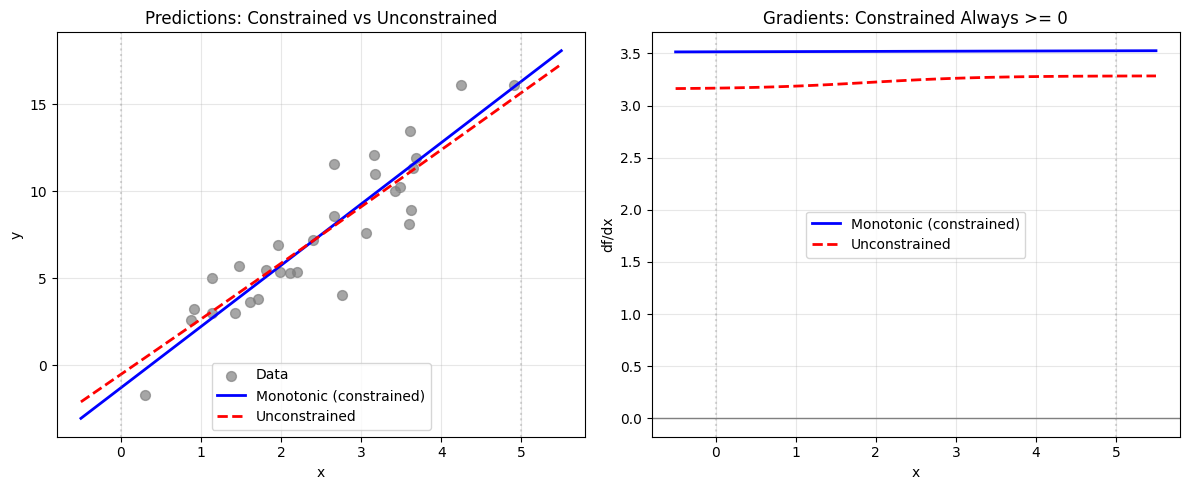

Unconstrained model: 0/100 points have negative gradient
Constrained model: 0 violations (guaranteed)


In [19]:
# Compare predictions
X_compare = np.linspace(-0.5, 5.5, 100).reshape(-1, 1)
y_const = model_constrained.predict(X_compare)
y_unconst = model_unconstrained.predict(X_compare)
g_const = model_constrained.predict_gradient(X_compare)
g_unconst = model_unconstrained.predict_gradient(X_compare)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Predictions
ax = axes[0]
ax.scatter(X_sparse, y_sparse, c="gray", s=50, alpha=0.7, label="Data")
ax.plot(X_compare, y_const, "b-", linewidth=2, label="Monotonic (constrained)")
ax.plot(X_compare, y_unconst, "r--", linewidth=2, label="Unconstrained")
ax.axvline(0, color="gray", linestyle=":", alpha=0.3)
ax.axvline(5, color="gray", linestyle=":", alpha=0.3)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Predictions: Constrained vs Unconstrained")
ax.legend()
ax.grid(True, alpha=0.3)

# Gradients
ax = axes[1]
ax.plot(X_compare, g_const, "b-", linewidth=2, label="Monotonic (constrained)")
ax.plot(X_compare, g_unconst, "r--", linewidth=2, label="Unconstrained")
ax.axhline(0, color="gray", linestyle="-", linewidth=1)
ax.axvline(0, color="gray", linestyle=":", alpha=0.3)
ax.axvline(5, color="gray", linestyle=":", alpha=0.3)

# Highlight violations
violations = g_unconst < 0
if np.any(violations):
    ax.fill_between(
        X_compare.ravel(),
        g_unconst.ravel(),
        0,
        where=violations.ravel(),
        alpha=0.3,
        color="red",
        label="Violations",
    )

ax.set_xlabel("x")
ax.set_ylabel("df/dx")
ax.set_title("Gradients: Constrained Always >= 0")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

n_violations = np.sum(g_unconst < -1e-6)
print(f"Unconstrained model: {n_violations}/{len(g_unconst)} points have negative gradient")
print("Constrained model: 0 violations (guaranteed)")

## 6. sklearn Compatibility

`JAXMonotonicRegressor` is fully compatible with sklearn's API.

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Create a pipeline
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "model",
            JAXMonotonicRegressor(
                hidden_dims=(16, 16),
                epochs=100,
                monotonicity=1,
                standardize_X=False,  # Don't double-standardize
            ),
        ),
    ]
)

# Cross-validation
scores = cross_val_score(pipe, X_inc, y_inc, cv=3, scoring="r2")
print(f"Cross-validation R² scores: {scores}")
print(f"Mean R²: {scores.mean():.4f} (+/- {scores.std():.4f})")

Cross-validation R² scores: [0.96330028 0.97408934 0.97159254]
Mean R²: 0.9697 (+/- 0.0046)


In [21]:
# Get/set parameters
model = JAXMonotonicRegressor(monotonicity=[1, -1], epochs=100)
params = model.get_params()
print("Model parameters:")
for k, v in params.items():
    print(f"  {k}: {v}")

Model parameters:
  activation: softplus
  alpha_squared: auto
  batch_size: 32
  epochs: 100
  hidden_dims: (32, 32)
  learning_rate: 0.005
  monotonicity: [1, -1]
  nonneg_param: softplus
  random_state: 42
  standardize_X: True
  standardize_y: True
  val_size: 0.1
  verbose: False
  weight_decay: 0.0
  zeta_squared: auto


## Summary

**JAXMonotonicRegressor** provides a sklearn-compatible implementation of monotonic neural networks with:

### Key Features:
- **Guaranteed monotonicity**: Per-feature increasing, decreasing, or unconstrained
- **LLPR uncertainty**: Calibrated uncertainty estimates without ensembles
- **Exact gradients**: Efficient gradient computation via JAX autodiff
- **sklearn API**: Works with pipelines, cross-validation, etc.

### When to Use:
1. **Prior knowledge**: When you know the direction of feature-target relationships
2. **Physical constraints**: Chemical rates, demand curves, dose-response
3. **Interpretability**: Monotonicity makes predictions easier to explain
4. **Regularization**: Constraints prevent overfitting to noise

### Parameters:
- `monotonicity`: +1 (increasing), -1 (decreasing), 0 (unconstrained)
- `hidden_dims`: Network architecture (default: (32, 32))
- `activation`: "softplus" or "relu" (default: softplus)
- `alpha_squared/zeta_squared`: LLPR calibration (default: 'auto')

### Methods:
- `fit(X, y)`: Train the model
- `predict(X)`: Make predictions
- `predict_with_uncertainty(X)`: Get (predictions, std)
- `predict_gradient(X)`: Compute df/dx
- `score(X, y)`: Compute R² score